In [23]:
import numpy as np # main library for numeric calculations
import pandas as pd # main library for data analysis
import matplotlib.pyplot as plt # main library for data plotting
import seaborn as sns # Another library for data plotting with more functions

import scipy as scp # STEM software
from scipy import signal
import scipy.interpolate as interpolate

from glob import glob # check files
from IPython.display import display, Markdown

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import lightkurve as lk
import astropy

import sys, os

file_path = os.getcwd()
print(file_path)
parent_dir = "\\".join(file_path.split("\\")[:-1])
print(parent_dir)

sys.path.append(parent_dir)

from merlion.utils import TimeSeries
from merlion.models.defaults import DefaultDetectorConfig, DefaultDetector
from merlion.plot import plot_anoms
from kepler import *

"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)"""

import warnings
warnings.filterwarnings('ignore') # literally to ignore all the warnings that don't matter


def printf(*args, sep=" ", end="\n"):
    string = sep.join([str(i) for i in args])+end
    display(Markdown(string))


C:\Users\Prannaya\ThreeBody\notebooks
C:\Users\Prannaya\ThreeBody


In [4]:
binarystars = pd.read_csv("../data/binarystars.csv").rename(columns={"KIC": "id"}).set_index("id")
configs = pd.read_csv("../data/binaryconfigs.csv")
configs.columns = ["id", "period", "duration", "depth"]
configs = configs.set_index("id")
binarystars

,period,period_err,bjd0,bjd0_err,morph,GLon,GLat,kmag,Teff,SC
id,,,,,,,,,,
3863594,0.053268,0.0,55000.000000,0.004327,0.79,-1.0000,-1.0000,-1.000,-1.0,False
10417986,0.073731,0.0,55000.027476,0.004231,0.99,81.0390,11.0820,9.128,-1.0,True
8912468,0.094838,0.0,54953.576945,0.005326,0.98,80.1095,7.8882,11.751,6194.0,False
8758716,0.107205,0.0,54953.672989,0.006197,1.00,77.7478,11.6565,13.531,-1.0,False
10855535,0.112782,0.0,54964.629315,0.006374,0.99,79.3949,15.9212,13.870,7555.0,False
...,...,...,...,...,...,...,...,...,...,...
9408440,989.985000,-1.0,55346.365980,0.096130,0.00,78.5607,12.2615,13.199,5688.0,False
8054233,1058.000000,-1.0,54751.806288,0.968052,0.03,78.6142,7.7321,11.783,4733.0,False
7672940,1064.270000,-1.0,54977.092960,0.089646,0.00,74.5296,14.6136,12.328,-1.0,False


In [5]:
def day2seconds(s):
    if type(s) in [float, int]:
        return s * 86400
    return float(s[:-2]) * 86400

configs["period"] = configs.period.apply(day2seconds)
configs["duration"] = configs.duration.apply(day2seconds)
configs = configs.dropna().sort_index()
configs

,period,duration,depth
id,,,
1026032,7.303493e+05,17280.0,0.003519
1026957,1.127302e+06,28512.0,0.001687
1161345,3.707062e+05,4320.0,0.000869
1295531,7.281519e+04,28512.0,0.007980
1571511,3.140644e+04,28512.0,0.000048
...,...,...,...
12598713,3.332850e+04,28512.0,0.011091
12599700,8.804085e+04,28512.0,0.038670
12644769,1.055417e+06,8640.0,0.007281


In [6]:
n = len(configs)
bins = int(np.sqrt(n))

periods = configs.period
durations = configs.duration
depths = configs.depth

percentiles = np.array([2.5, 25, 50, 75, 97.5])

In [7]:
mu_period = periods.mean()
sigma_period = periods.std()
var_period = np.var(periods)
ptiles_per = np.percentile(periods, percentiles)

mu_duration = durations.mean()
sigma_duration = durations.std()
var_duration = np.var(durations)
ptiles_dur = np.percentile(durations, percentiles)

mu_depth = depths.mean()
sigma_duration = depths.std()
var_depth = np.var(depths)
ptiles_dep = np.percentile(depths, percentiles)

In [8]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def plot_hist(data, xlabel, ylabel="count", bins=bins, ax=None, **kwargs):
    if not ax:
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111)
    
    ax.hist(data, bins=bins, **kwargs)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

    
def plot_ecdf(data, xlabel, ptiles, ylabel="ECDF", ax=None, marker=".", linestyle="none", **kwargs):
    if not ax:
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111)
        
    # Retrive ECDF
    x, y = ecdf(data)

    # Generate plot
    ax.plot(x, y, marker=marker, linestyle=linestyle, **kwargs)

    # Label the axes
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.plot(ptiles, percentiles/100, marker='D', color='red',
         linestyle="none")

    # Display the plot
    plt.show()

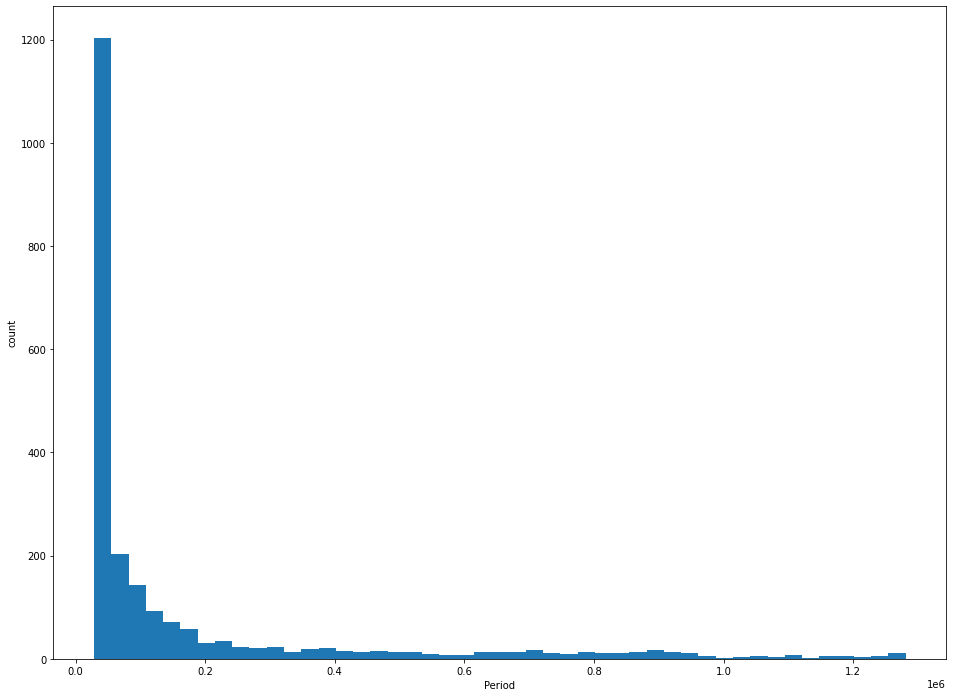

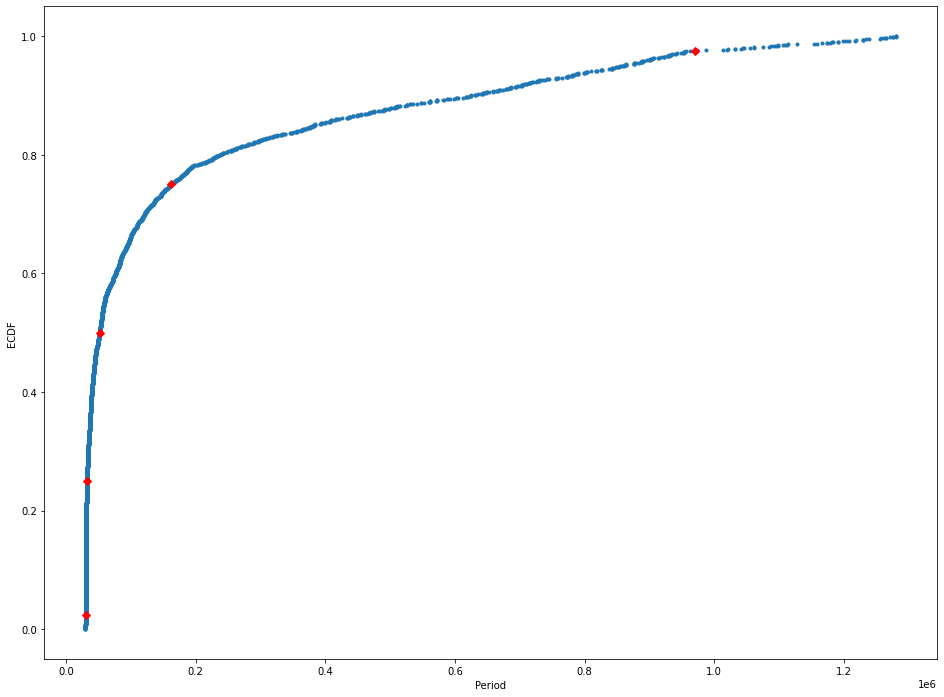

In [12]:
plot_hist(periods, "Period")
plot_ecdf(periods, "Period", ptiles_per)

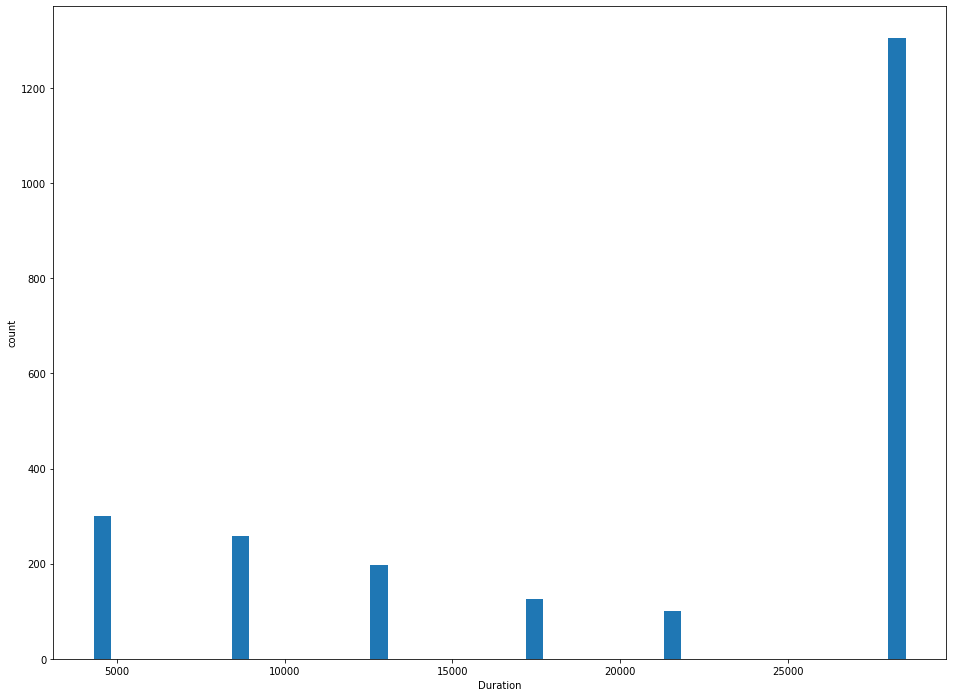

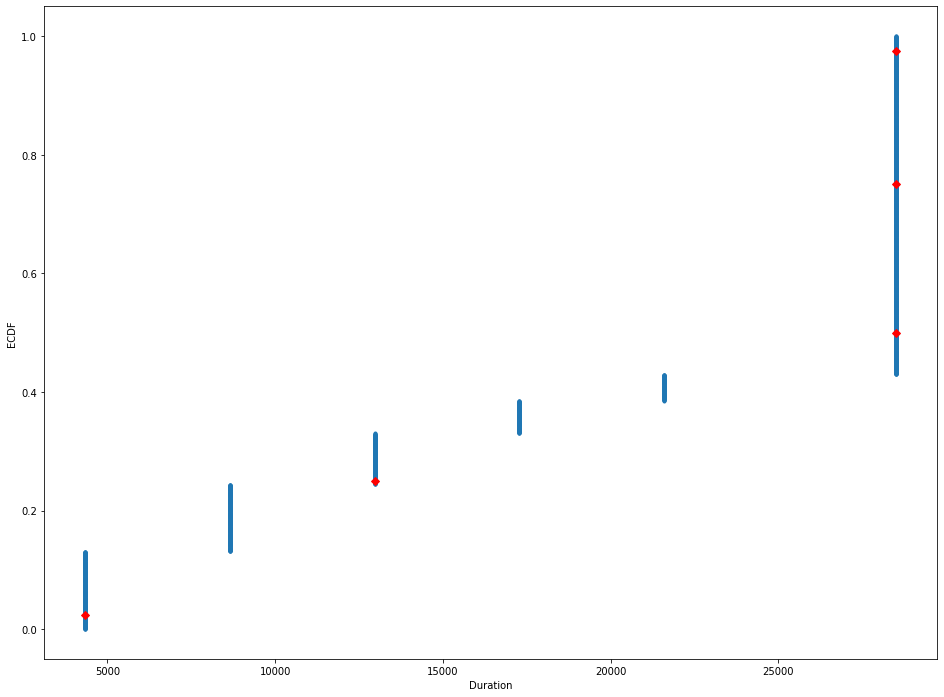

In [13]:
plot_hist(durations, "Duration")
plot_ecdf(durations, "Duration", ptiles_dur)

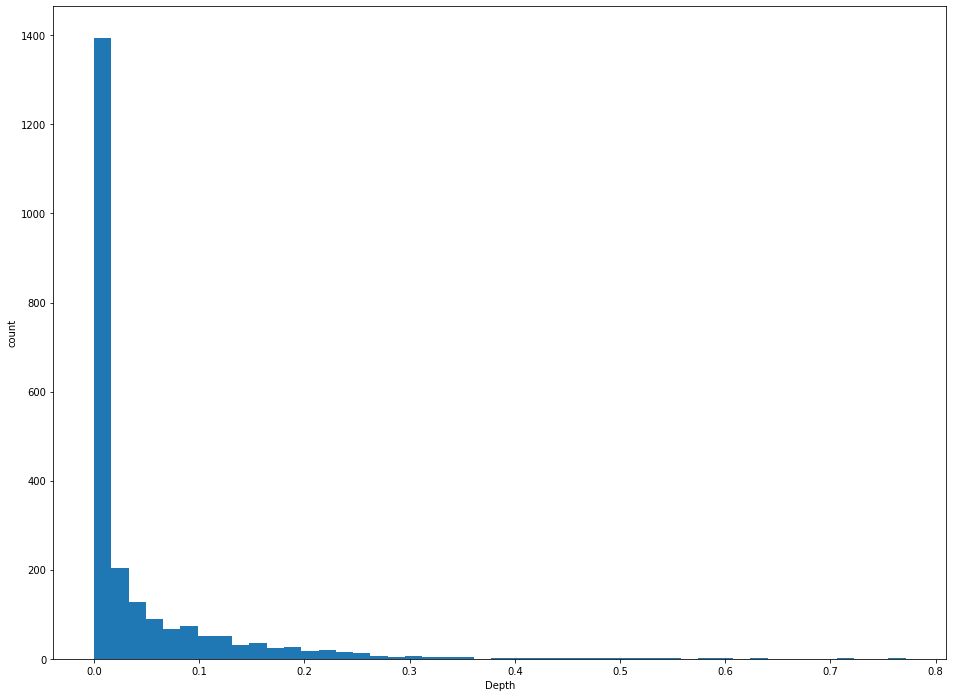

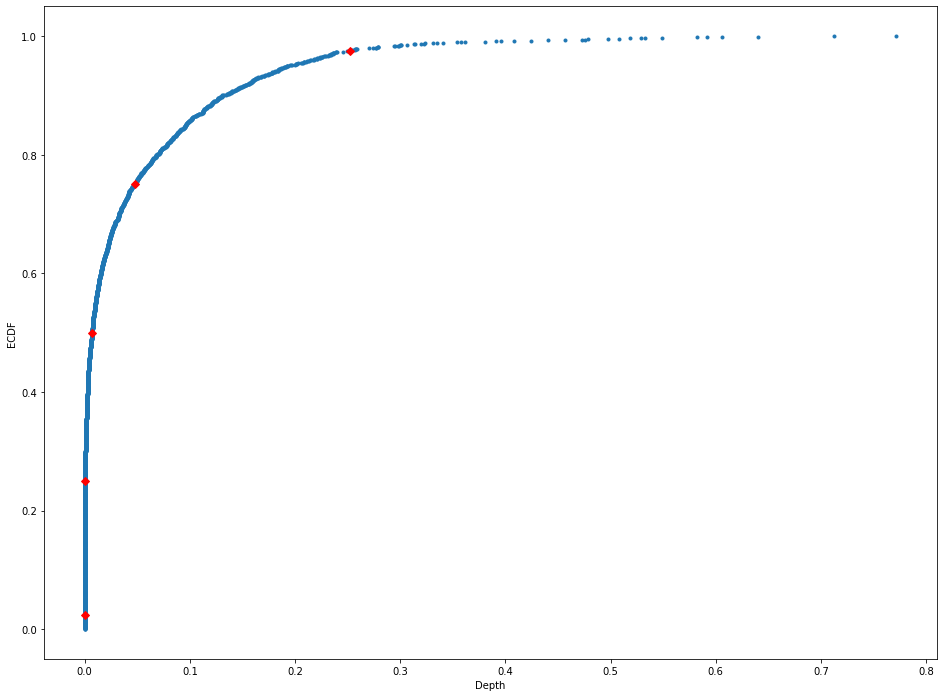

In [14]:
plot_hist(depths, "Depth")
plot_ecdf(depths, "Depth", ptiles_dep)

In [15]:
cov_perdur = np.cov(periods, durations)
cov_perdep = np.cov(periods, depths)
cov_durdep = np.cov(durations, depths)

In [16]:
configs.corr()

,period,duration,depth
period,1.000000,-0.288703,-0.099790
duration,-0.288703,1.000000,-0.173623
depth,-0.099790,-0.173623,1.000000


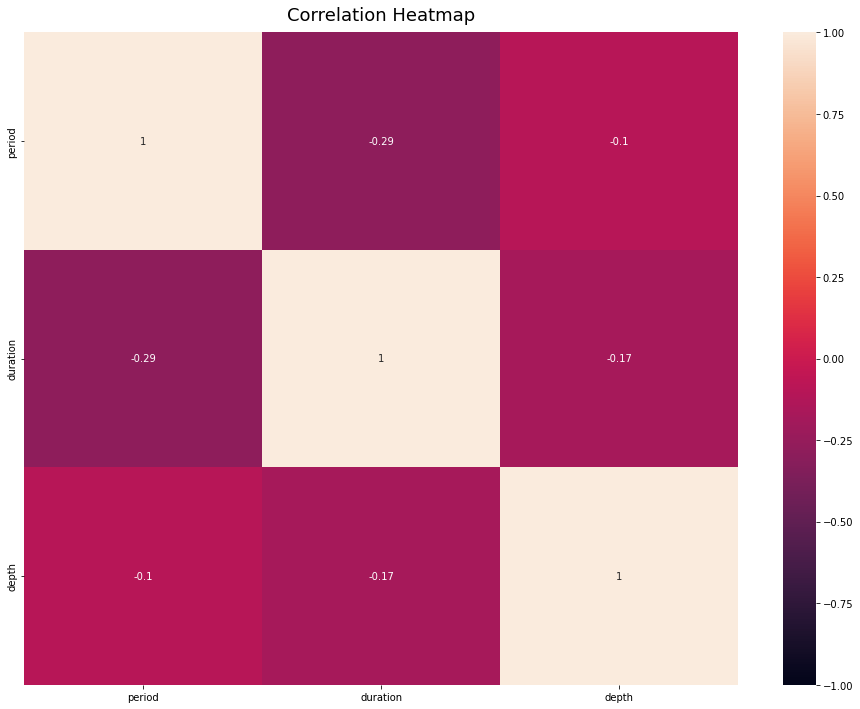

In [17]:
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(configs.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

In [18]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]

pearson_perdur = pearson_r(periods, durations)
pearson_perdep = pearson_r(periods, depths)
pearson_durdep = pearson_r(durations, depths)

In [19]:
def evaluateAndProcessData(x, y):
    t, c, k = interpolate.splrep(x, y, s=0, k=4)
    xx = np.linspace(x.min(), x.max(), 100)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    
    plt.figure(figsize=(16,6))
    plt.plot(x, y, "bo", linestyle="none", label='Original points')
    plt.plot(x, y)
    plt.plot(xx, spline(xx), 'r', label='BSpline')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
# Retrieving all the important details
def getData(id):
    try:
        return retrieveKeplerLightCurve(id)
    except:
        return None


In [25]:
ids = list(configs.index)
id2 = np.random.choice(ids)
id2

7620664

In [26]:
lc = getData(id2)
lc

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
131.51207539832103,1.0056552e+00,1.0558798e-04,0,1.081578e-03,1035.70877,615.56640,1105,8.3639742e+04,7.7817411e+00,9.7082031e+02,3.0992335e-01,8.6880758e+04,9.1219778e+00,0,nan,nan,nan,nan,1035.70877,5.0266914e-05,615.56640,5.2634910e-05,1.8485578e-02,-1.3948931e-02
131.53250999564625,9.8020810e-01,1.0462316e-04,0,1.082476e-03,1035.70995,615.56091,1106,8.1979742e+04,7.7113800e+00,9.7083081e+02,3.0956209e-01,8.4682328e+04,9.0386238e+00,0,nan,nan,nan,nan,1035.70995,5.0622144e-05,615.56091,5.3018866e-05,1.8405186e-02,-1.3859524e-02
131.55294449286157,9.5793170e-01,1.0365670e-04,0,1.083373e-03,1035.71127,615.55569,1107,8.0357297e+04,7.6401815e+00,9.7111713e+02,3.0966699e-01,8.2757820e+04,8.9551296e+00,0,nan,nan,nan,nan,1035.71127,5.0988005e-05,615.55569,5.3420361e-05,1.8304540e-02,-1.3972014e-02
131.57337889006885,9.3729794e-01,1.0280955e-04,0,1.084270e-03,1035.71211,615.55053,1108,7.8840852e+04,7.5785437e+00,9.7199908e+02,3.0979311e-01,8.0975227e+04,8.8819427e+00,0,nan,nan,nan,nan,1035.71211,5.1340539e-05,615.55053,5.3802090e-05,1.8177060e-02,-1.4192468e-02
131.59381338728417,9.2384285e-01,1.0223787e-04,0,1.085167e-03,1035.71369,615.54696,1109,7.7827984e+04,7.5342569e+00,9.7098151e+02,3.1006980e-01,7.9812812e+04,8.8325539e+00,0,nan,nan,nan,nan,1035.71369,5.1550975e-05,615.54696,5.4045122e-05,1.8723430e-02,-1.4026637e-02
131.61424798450025,9.2260921e-01,1.0210960e-04,0,1.086064e-03,1035.71371,615.54638,1110,7.7692812e+04,7.5257444e+00,9.7113031e+02,3.1005716e-01,7.9706234e+04,8.8214722e+00,0,nan,nan,nan,nan,1035.71371,5.1570380e-05,615.54638,5.4068838e-05,1.8595565e-02,-1.3954886e-02
131.6346823815984,9.3449450e-01,1.0266271e-04,0,1.086962e-03,1035.71295,615.54908,1111,7.8499289e+04,7.5646133e+00,9.7074982e+02,3.0977046e-01,8.0733031e+04,8.8692570e+00,0,nan,nan,nan,nan,1035.71295,5.1383198e-05,615.54908,5.3866290e-05,1.8582996e-02,-1.3887599e-02
131.65511687869002,9.5536852e-01,1.0346054e-04,0,1.087859e-03,1035.71191,615.55386,1112,7.9941336e+04,7.6232958e+00,9.7023401e+02,3.0966356e-01,8.2536383e+04,8.9381838e+00,0,nan,nan,nan,nan,1035.71191,5.1041563e-05,615.55386,5.3489537e-05,1.8726256e-02,-1.3702850e-02


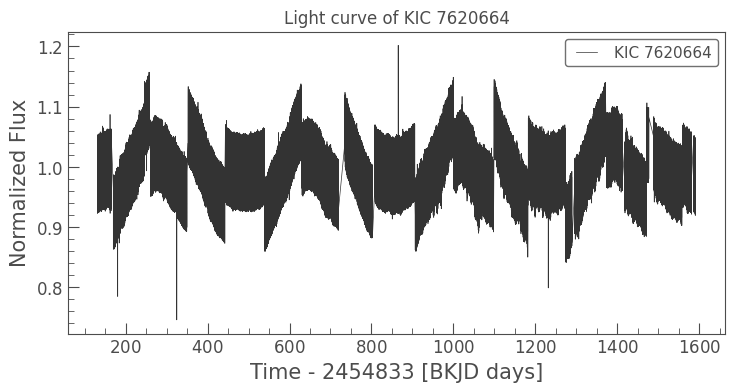

In [27]:
plotKeplerLightCurve(lc)
plt.show()

In [31]:
flux = pd.DataFrame(np.array(lc)).set_index("time").flux
flux

time
131.51207539832103    1.005655
131.53250999564625    0.980208
131.55294449286157    0.957932
131.57337889006885    0.937298
131.59381338728417    0.923843
                        ...   
1590.9193362095248    0.979661
1590.9397707687676    0.981730
1590.960205228097     0.923968
1590.980639587513     0.930914
1591.0010741470323    0.927371
Name: flux, Length: 64793, dtype: float32

In [32]:
train_data = TimeSeries.from_pd(flux)
train_data

                         flux
1970-01-01 00:00:00  1.005655
1970-01-01 01:00:00  0.980208
1970-01-01 02:00:00  0.957932
1970-01-01 03:00:00  0.937298
1970-01-01 04:00:00  0.923843
...                       ...
1977-05-23 12:00:00  0.979661
1977-05-23 13:00:00  0.981730
1977-05-23 14:00:00  0.923968
1977-05-23 15:00:00  0.930914
1977-05-23 16:00:00  0.927371

[64793 rows x 1 columns]

In [33]:
model = DefaultDetector(DefaultDetectorConfig())
model.train(train_data=train_data)
model.plot_anomaly(time_series=train_data)

IndexError: index -1 is out of bounds for axis 0 with size 0